In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# import numdifftools as nd

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [24, 16]

In [2]:
def f(x, y):
     return x ** 2 + y ** 2
    
def gradient(v):
    return np.array([2 * v[0], 2 * v[1]])

In [3]:
def painter_decorator3d(func):
    def draw(*args, **kwargs):
        points = func(*args, **kwargs)
        xx = points[:, 0]
        yy = points[:, 1]
        zz = f(xx, yy)
        
        lim = max(max(xx), max(yy))
        x = np.linspace(-lim, lim, 300)
        y = np.linspace(-lim, lim, 300)
        x, y = np.meshgrid(x, y)
        z = f(x, y)

        figure = plt.figure()
        figure.patch.set_facecolor('w')
        std_view = figure.add_subplot(1, 2, 1, projection='3d')
        std_view.contour(x, y, z, 50, alpha=.4, cmap='binary')
        std_view.scatter(xx, yy, zz, color='white', cmap=None, s=30, alpha=.8)
        std_view.plot(xx, yy, zz, color='cyan', alpha=.7, linestyle='--')
        std_view.axis('off')
        
        upper_view = figure.add_subplot(1, 2, 2, projection='3d')
        upper_view.contour(x, y, z, 50, alpha=.4, cmap='binary')
        upper_view.scatter(xx, yy, zz, color='white', s=30, alpha=.8)
        upper_view.plot(xx, yy, zz, color='cyan', alpha=.7, linestyle='--')
        upper_view.view_init(90, 0)
        upper_view.axis('off')
        print(f'Iterations: {len(points)}, result: {np.append(points[-1], zz[-1])}')
    return draw

## 1. Gradient descent with constant learning rate

In [4]:
@painter_decorator3d
def gradient_descent_const(start_point, learning_rate, tolerance=1e-5, n_iter=100):
    points = np.array([start_point])
    for _ in range(n_iter):
        step = -learning_rate * gradient(points[-1])
        if np.all(np.abs(step) < tolerance):
            break

        new_point = points[-1] + step
        points = np.concatenate((points, np.array([new_point])))
    return points

### Optimal learning rate

Iterations: 27, result: [1.70581728e-05 1.70581728e-05 5.81962520e-10]


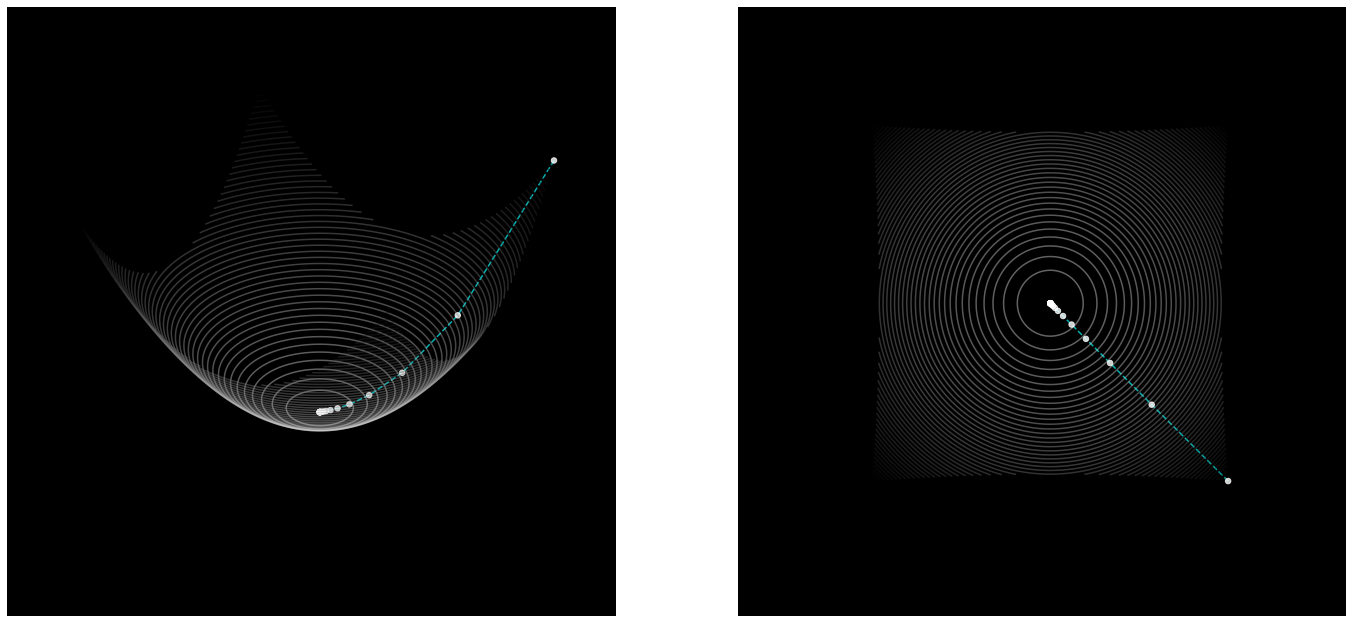

In [5]:
gradient_descent_const(np.array([10, 10]), 0.2)

### Large learning rate

Iterations: 66, result: [-5.02168139e-06 -5.02168139e-06  5.04345679e-11]


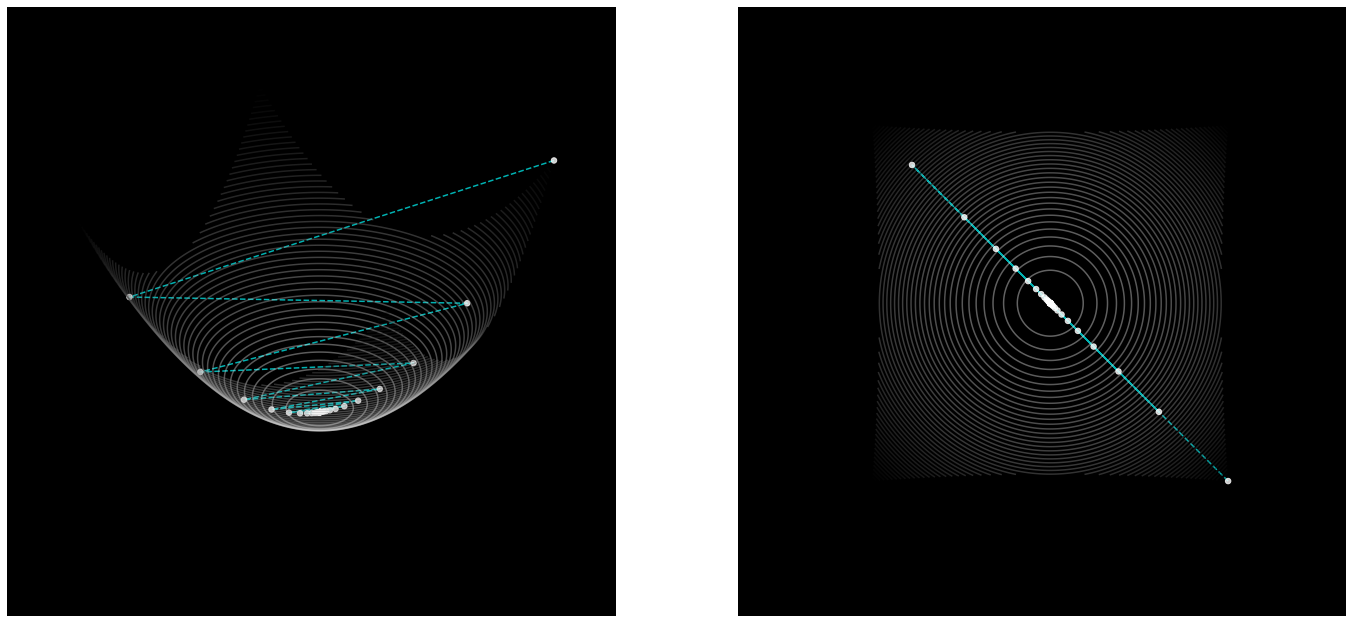

In [6]:
gradient_descent_const(np.array([10, 10]), 0.9)

### Small learning rate

Iterations: 101, result: [1.32619556 1.32619556 3.51758932]


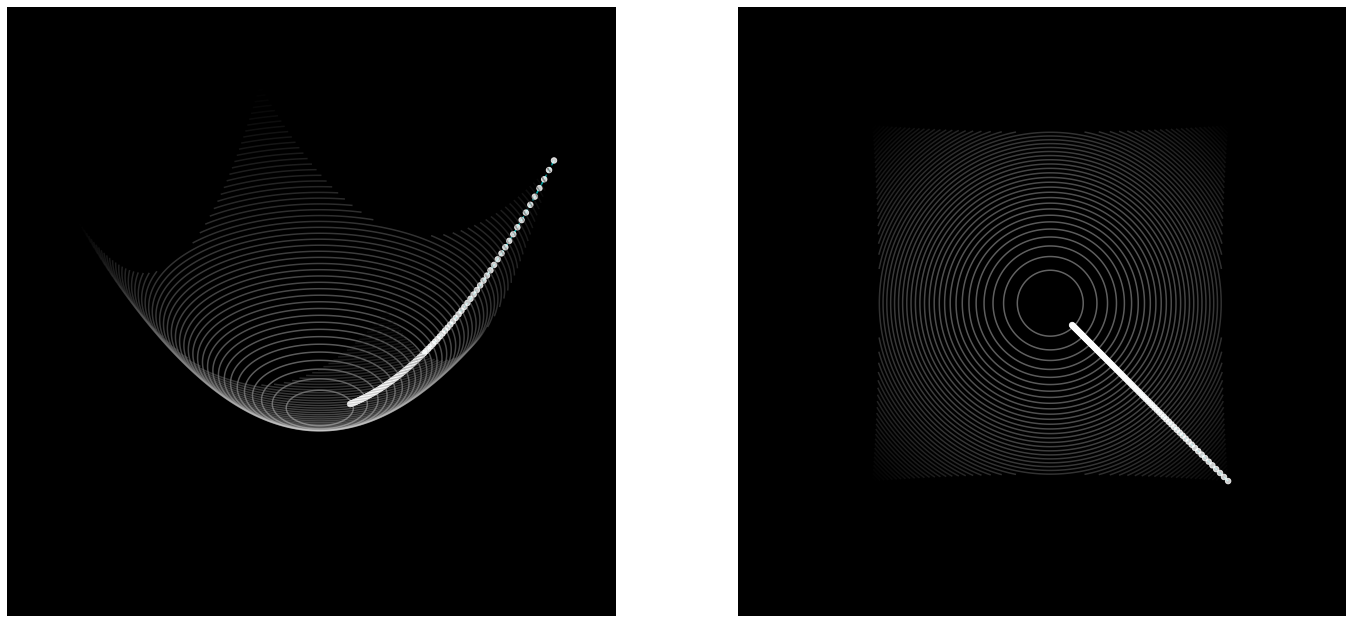

In [7]:
gradient_descent_const(np.array([10, 10]), 0.01)

## 2. Gradient descent with "step crushing" - метод дробления шага

In [8]:
@painter_decorator3d
def gradient_descent_step_crushing(start_point, learning_rate=1, tolerance=1e-3, n_iter=100, eps=0.1):
    points = np.array([start_point])
    prev_function_value = f(start_point[0], start_point[1])
    current_learning_rate = learning_rate

    for i in range(n_iter):
        step = -current_learning_rate * gradient(points[-1])
        if np.all(np.abs(step) < tolerance):
            break

        new_point = points[-1] + step
        fnew_point = f(new_point[0], new_point[1])
        if fnew_point - prev_function_value > -eps * current_learning_rate * (np.linalg.norm(points[-1], 2) ** 2):
            current_learning_rate *= .5;
            i -= 1
            continue

        points = np.concatenate((points, np.array([new_point])))
        prev_function_value = fnew_point
    return points

Iterations: 2, result: [0. 0. 0.]


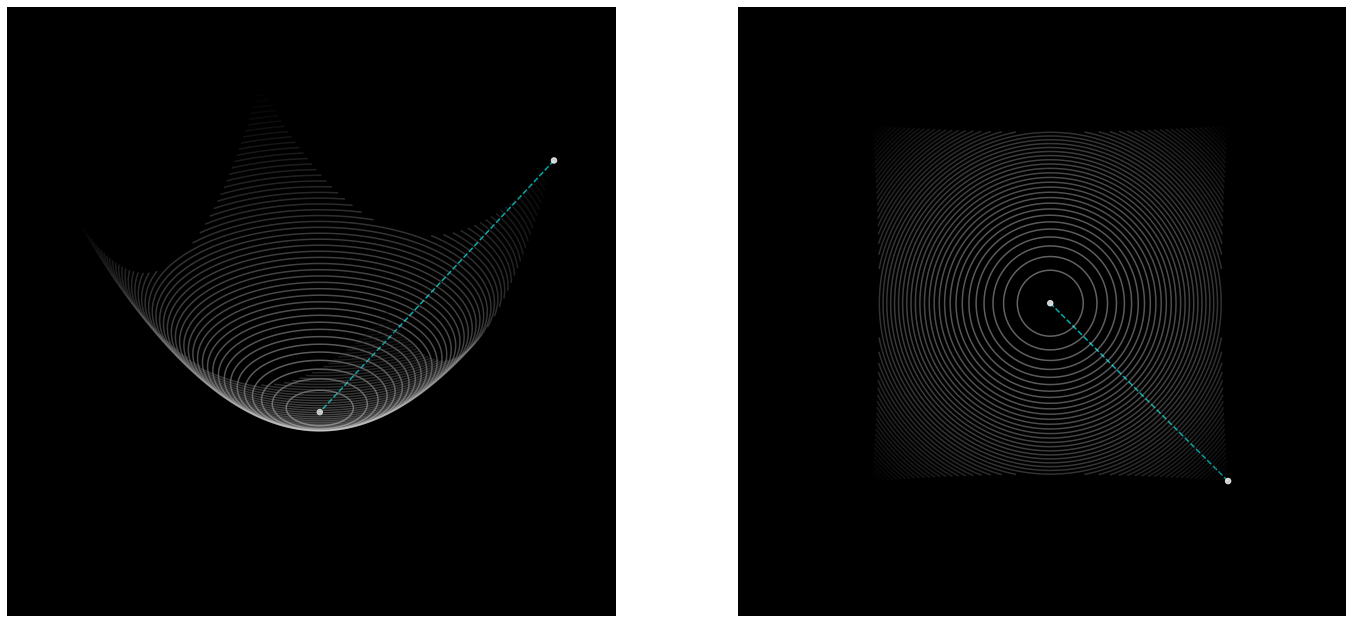

In [9]:
gradient_descent_step_crushing(np.array([10, 10]), 1)

## 3. Gradient descent with 1D optimization techniques